In [2]:
from typing import Callable
from functools import partial

import cv2
from matplotlib import pyplot as plt
import numpy as np

In [3]:
d_h = cv2.imread('data/detalization_h.png', 0)
d_l = cv2.imread('data/detalization_l.png', 0)
c_h = cv2.imread('data/contrast_h.png', 0)
c_l = cv2.imread('data/contrast_l.png', 0)

In [4]:
def show_image(img: np.ndarray):
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()

def show_images_sbs(img1: np.ndarray, img2: np.ndarray):
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    plt.imshow(img1, cmap='gray', vmin=0, vmax=255)
    plt.subplot(122)
    plt.imshow(img2, cmap='gray', vmin=0, vmax=255)
    plt.show()

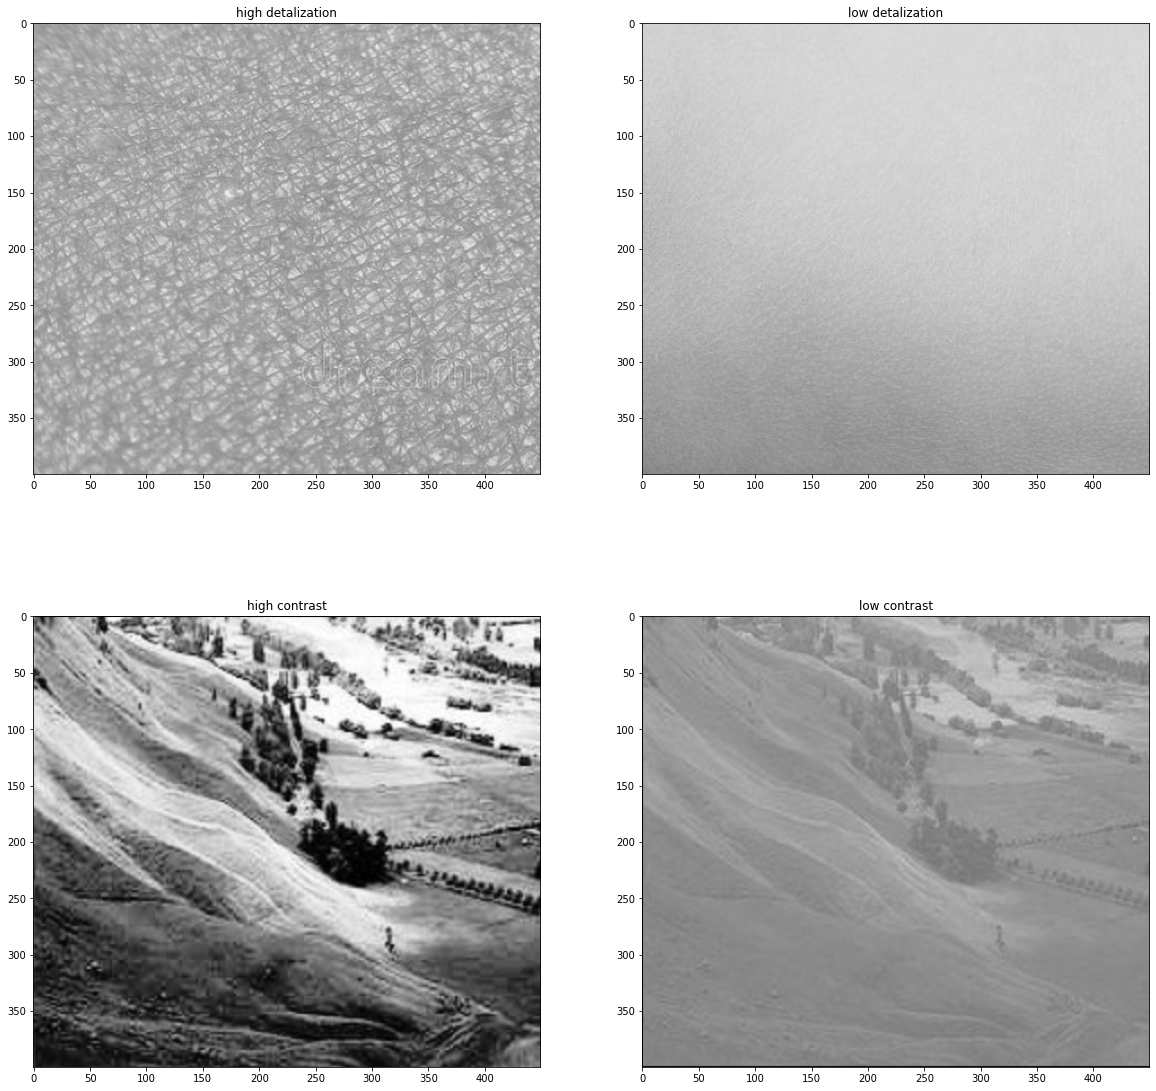

In [5]:
plt.figure(figsize=(20, 20))
plt.subplot(221)
plt.title('high detalization')
plt.imshow(d_h, cmap='gray', vmin=0, vmax=255)
plt.subplot(222)
plt.title('low detalization')
plt.imshow(d_l, cmap='gray', vmin=0, vmax=255)
plt.subplot(223)
plt.title('high contrast')
plt.imshow(c_h, cmap='gray', vmin=0, vmax=255)
plt.subplot(224)
plt.title('low contrast')
plt.imshow(c_l, cmap='gray', vmin=0, vmax=255)
plt.show()

In [6]:
def generic_2d(kernel: np.ndarray, aggregation: Callable[[np.ndarray], np.ndarray]) -> Callable[[np.ndarray], np.ndarray]:
    def linear_2d_transform(img: np.ndarray) -> np.ndarray:
        r, c = img.shape
        kr, kc = kernel.shape
        result = np.zeros((r - kr + 1, c - kc + 1))
        for row in range(r - kr + 1):
            for col in range(c - kc + 1):
                result[row, col] = aggregation(img[row:row+kr, col:col+kc] * kernel)
        result[result > 255] = 255
        result[result < 0] = 0
        result = result.astype(int)
        return result
    return linear_2d_transform

linear_2d = partial(generic_2d, aggregation=np.sum)

In [7]:
def gaussian_kernel(size, sigma):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

In [8]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = linear_2d(Kx)(img)
    Iy = linear_2d(Ky)(img)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return G, theta

In [9]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

In [10]:
def threshold(img, low_threshold_ratio=0.05, high_threshold_ratio=0.09):
    
    high_threshold = img.max() * high_threshold_ratio;
    low_threshold = high_threshold * low_threshold_ratio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= high_threshold)
    zeros_i, zeros_j = np.where(img < low_threshold)
    
    weak_i, weak_j = np.where((img <= high_threshold) & (img >= low_threshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return res

In [11]:
def hysteresis(img):
    weak = 25
    strong = 255
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

In [12]:
def canny(img, sigma=1, kernel_size=1, low_threshold=0.05, high_threshold=0.2):
    img_smoothed = linear_2d(gaussian_kernel(kernel_size, sigma))(img)
    gradient, theta = sobel_filters(img_smoothed)
    non_max_img = non_max_suppression(gradient, theta)
    threshold_img = threshold(non_max_img, low_threshold, high_threshold)
    return hysteresis(threshold_img)

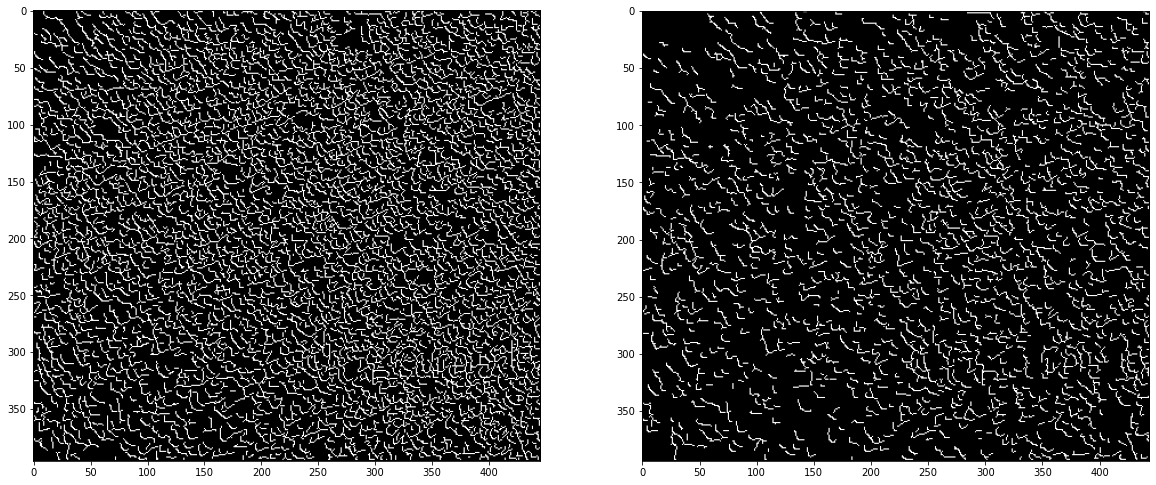

In [13]:
show_images_sbs(
    canny(d_h, kernel_size=3, low_threshold=0.15, high_threshold=0.2),
    canny(d_h, kernel_size=5, low_threshold=0.05, high_threshold=0.4),
)

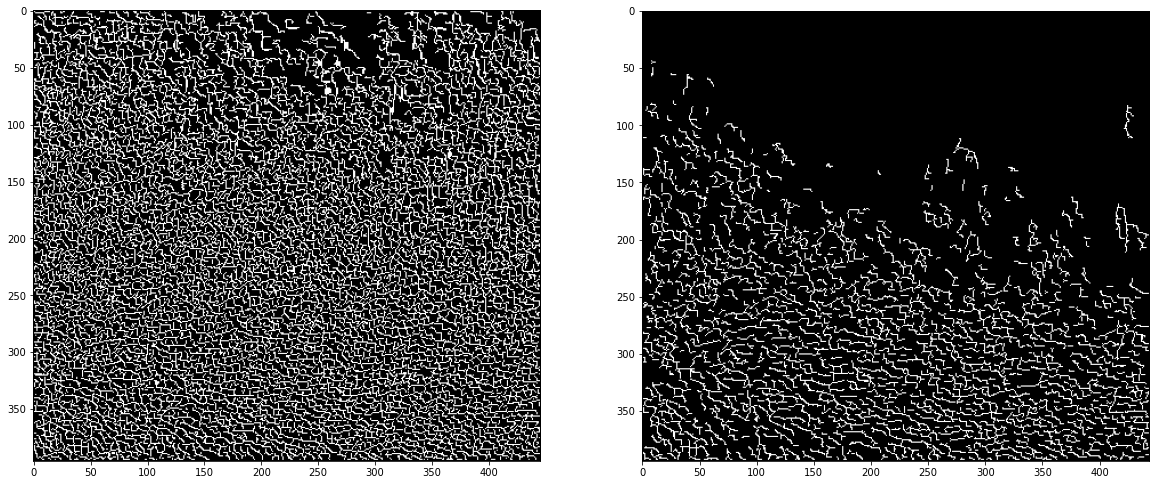

In [14]:
show_images_sbs(
    canny(d_l, kernel_size=3, low_threshold=0.03, high_threshold=0.1),
    canny(d_l, kernel_size=5, low_threshold=0.2, high_threshold=0.4),
)

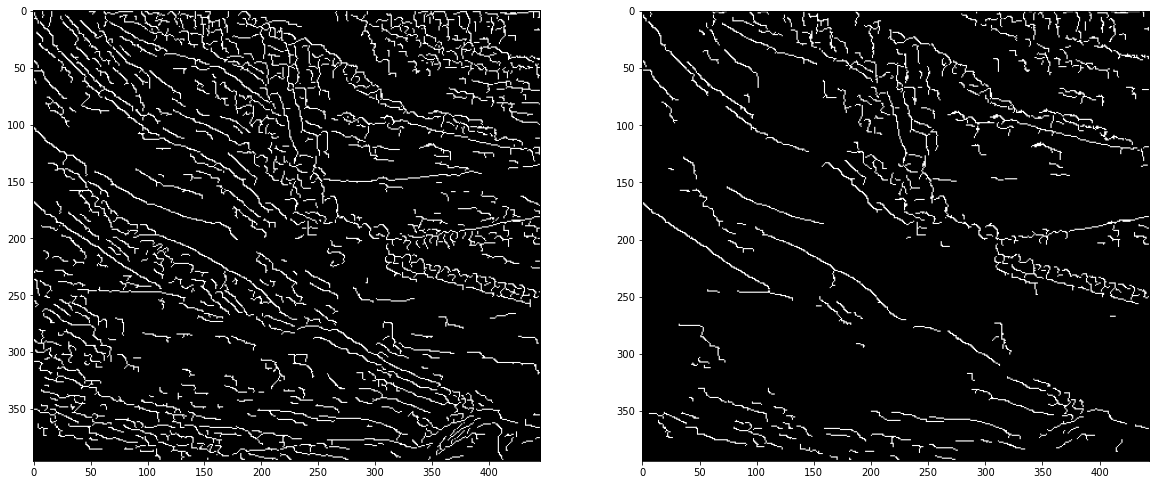

In [15]:
show_images_sbs(
    canny(c_h, kernel_size=3, low_threshold=0.05, high_threshold=0.2),
    canny(c_h, kernel_size=5, low_threshold=0.05, high_threshold=0.4),
)

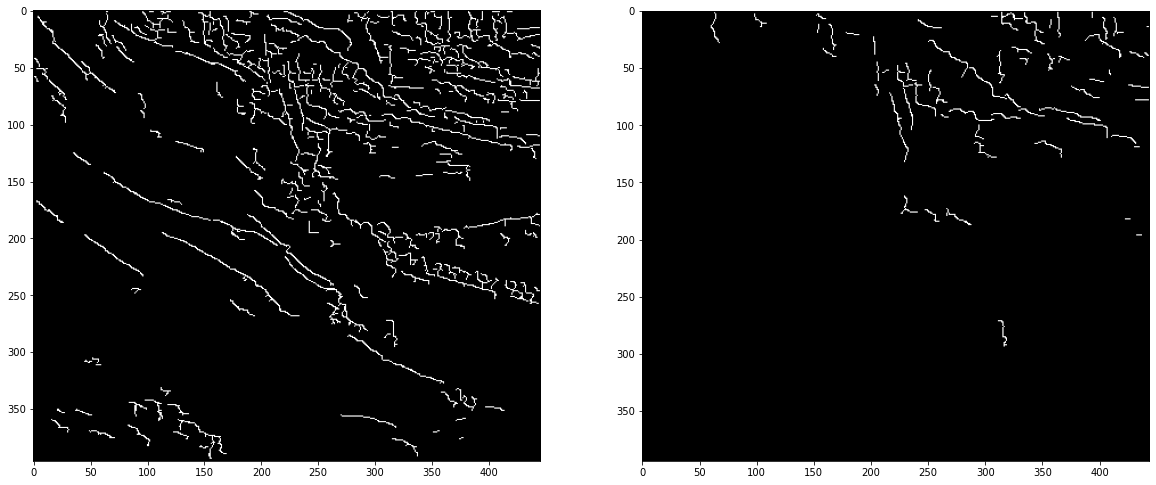

In [16]:
show_images_sbs(
    canny(c_l, kernel_size=3, low_threshold=0.05, high_threshold=0.2),
    canny(c_l, kernel_size=5, low_threshold=0.05, high_threshold=0.4),
)

-canny performs good on contrast high quality images
-low contrast = too many edges
-too high contrast = too many edges
